In [0]:
#export
from torch import optim
from nb_fastai import *
import torch.nn.functional as F

In [0]:
import torch.nn.functional as F

In [0]:
% reload_ext autoreload
% autoreload 2

% matplotlib inline

In [0]:
loss_func = F.cross_entropy

In [0]:
#export
def accuracy(out, yb):
    return (torch.argmax(out, dim=1) == yb).float().mean()

In [0]:
MNIST_URL = "http://deeplearning.in/data/mnist/mnist.pkl"

In [0]:
x_train, y_train, x_valid, y_valid = get_data(url=MNIST_URL)

In [0]:
assert x_train.shape[0] == y_train.shape[0]
assert x_valid.shape[0] == y_valid.shape[0]

In [0]:
from torch import optim

## Dataset

In [0]:
#export
class Dataset():
    def __init__(self, x, y):
        self.x, self.y = x, y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [0]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [0]:
len(train_ds), len(valid_ds)

(50000, 10000)

In [0]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [0]:
bs = 64

In [0]:
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False)

In [0]:
len(train_dl), len(valid_dl)

(781, 157)

In [0]:
nh = 50
c = y_train.max() + 1
n, m = x_train.shape

In [0]:
lr = 1e-2

In [0]:
c, n, m, nh

(tensor(10), 50000, 784, 50)

In [0]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [0]:
model, opt = get_model()

tensor(9)

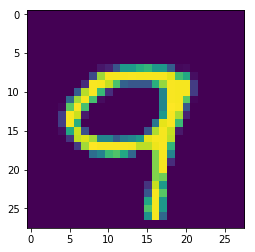

In [0]:
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28, 28))
yb[0]

In [0]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc = 0., 0.
            for xb, yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy(pred, yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [0]:
fit(15, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.6887) tensor(0.8582)
1 tensor(0.4342) tensor(0.8921)
2 tensor(0.3668) tensor(0.9006)
3 tensor(0.3329) tensor(0.9093)
4 tensor(0.3148) tensor(0.9130)
5 tensor(0.3002) tensor(0.9169)
6 tensor(0.2889) tensor(0.9202)
7 tensor(0.2805) tensor(0.9219)
8 tensor(0.2703) tensor(0.9239)
9 tensor(0.2636) tensor(0.9260)
10 tensor(0.2557) tensor(0.9286)
11 tensor(0.2498) tensor(0.9311)
12 tensor(0.2429) tensor(0.9324)
13 tensor(0.2369) tensor(0.9336)
14 tensor(0.2324) tensor(0.9349)


(tensor(0.2324), tensor(0.9349))

### Callbacks
### Databunch, DataLearner


In [0]:
x_train, y_train, x_valid, y_valid = get_data()

In [0]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 64
c = y_train.max().item() + 1
loss_func = F.cross_entropy



Factor out the connected pieces of info out of the fit() argument list

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Let's replace it with something that looks like this:

fit(1, learn)

This will allow us to tweak what's happening inside the training loop in other places of the code because the Learner object will be mutable, so changing any of its attribute elsewhere will be seen in our training loop.


In [0]:
#export
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl, self.valid_dl, c = train_dl, valid_dl, c
        
    @property
    def train_ds(self):
        return self.train_dl.dataset
    
    @property
    def valid_ds(self):
        return self.valid_dl.daataset

In [0]:
def get_dls(train_dl, valid_dl, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
                DataLoader(valid_ds, batch_size=bs*2, shuffle=False, **kwargs))

In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model, self.opt, self.loss_func, self.data = model, opt, loss_func, data

In [0]:
learn = Learner(model, opt, loss_func, data)

In [0]:
def fit(epochs, learn):
    for epoch in range(epochs):
        learn.model.train()
        for xb, yb in learn.data.train_dl:
            loss = learn.loss_func(learn.model(xb), yb)
            loss.backward()
            learn.opt.step()
            learn.opt.zero_grad()
            
        learn.model.eval()
        with torch.no_grad():
            tot_loss, tot_acc = 0., 0.
            for xb, yb in learn.data.valid_dl:
                pred = learn.model(xb)
                tot_loss += learn.loss_func(pred, yb)
                tot_acc  += accuracy(pred, yb)
        nv = len(learn.data.valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [0]:
fit(15, learn)

0 tensor(0.2263) tensor(0.9369)
1 tensor(0.2204) tensor(0.9385)
2 tensor(0.2163) tensor(0.9407)
3 tensor(0.2109) tensor(0.9416)
4 tensor(0.2081) tensor(0.9426)
5 tensor(0.2030) tensor(0.9449)
6 tensor(0.2008) tensor(0.9448)
7 tensor(0.1956) tensor(0.9466)
8 tensor(0.1924) tensor(0.9476)
9 tensor(0.1902) tensor(0.9488)
10 tensor(0.1861) tensor(0.9497)
11 tensor(0.1828) tensor(0.9503)
12 tensor(0.1801) tensor(0.9506)
13 tensor(0.1775) tensor(0.9515)
14 tensor(0.1744) tensor(0.9524)


(tensor(0.1744), tensor(0.9524))

## Runner
### callbacks

This was our training loop (without validation) from the previous notebook, with the inner loop contents factored out:



In [0]:
#export
import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')

def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

In [0]:
#export
class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')


In [0]:
#export
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs = 0
        self.run.n_iter = 0
        
    def after_batch(self):
        if not self.in_train:
            return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs = self.epoch
        self.model.train()
        self.run.in_train = True
        
    def begin_validate(self):
        self.model.eval()
        self.run.in_train = False

In [0]:
class TestCallback(Callback):
    def after_step(self):
        if self.train_eval.n_iters >= 10:
            return True

In [0]:
cbname = 'TrainEvalCallback'
camel2snake(cbname)

'train_eval_callback'

In [0]:
TrainEvalCallback().name

'train_eval'

In [0]:
#export
from typing import *

def listify(o):
    if o is None:
        return []    
    if isinstance(o, list):
        return o    
    if isinstance(o, str):
        return [o]    
    if isinstance(o, Iterable):
        return list(o)
    return [o]

In [0]:
#export
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop, self.cbs = False, [TrainEvalCallback()] + cbs
        
    @property
    def opt(self):
        return self.learn.opt
    
    @property
    def model(self):
        return self.learn.model
    
    @property
    def loss_func(self):
        return self.learn.loss_func
    
    @property
    def data(self):
        return self.learn.data
    
    def one_batch(self, xb, yb):
        self.xb, self.yb = xb, yb
        if self("begin_batch"):    return 
        self.pred = self.model(self.xb)
        if self("after_pred"):     return
        self.loss = self.loss_func(self.pred, self.yb)
        if self("after_loss") or not self.in_train:    return
        self.loss.backward()
        if self("after_backward"):    return
        self.opt.step()
        if self("after_step"):    return
        self.opt.zero_grad()
        
        
    def all_batches(self, dl):
        self.iters = len(dl)
        for xb, yb in dl:
            self.one_batch(xb, yb)
            self("after_batch")
        self.stop = False
        
    def fit(self, epochs, learn):
        self.epochs, self.learn = epochs, learn
        try:
            for cb in self.cbs:
                cb.set_runner(self)
            if self("begin_fit"):       return
            for epoch in range(epochs):
                self.epoch = epoch
                if not self("begin_epoch"):
                    self.all_batches(self.data.train_dl)
                with torch.no_grad():
                    if not self("begin_validate"):
                        self.all_batches(self.data.valid_dl)
                if self("after_epoch"):
                    break
                    
        finally:
            self("after_fit")
            self.learn = None
            
    def __call__(self, cb_name):
        for cb in sorted(self.cbs, key=lambda x: x._order):
            f = getattr(cb, cb_name, None)
            if f and f():
                return True
        return False

In [0]:
#export
class AvgStats():
    def __init__(self, metrics, in_train): self.metrics,self.in_train = listify(metrics),in_train
    
    def reset(self):
        self.tot_loss,self.count = 0.,0
        self.tot_mets = [0.] * len(self.metrics)
        
    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]
    
    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn

In [0]:
#export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

In [0]:
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))
    return model, optim.SGD(model.parameters(), lr=lr)

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model, self.opt, self.loss_func, self.data = model, opt, loss_func, data

In [0]:
learn = Learner(*get_model(data), loss_func, data)

In [0]:
stats = AvgStatsCallback([accuracy])
run = Runner(cbs=stats)

In [0]:
run.fit(5, learn)

train: [0.3121986328125, tensor(0.9034)]
valid: [0.1439669921875, tensor(0.9577)]
train: [0.146643154296875, tensor(0.9558)]
valid: [0.3085468994140625, tensor(0.9064)]
train: [0.1124756640625, tensor(0.9645)]
valid: [0.11985174560546875, tensor(0.9661)]
train: [0.090271708984375, tensor(0.9719)]
valid: [0.1315910400390625, tensor(0.9621)]
train: [0.079008515625, tensor(0.9757)]
valid: [0.117642041015625, tensor(0.9670)]


In [0]:
loss, acc = stats.valid_stats.avg_stats
assert acc > 0.9
loss, acc

(0.117642041015625, tensor(0.9670))

In [0]:
from functools import partial

In [0]:
acc_cbf = partial(AvgStatsCallback, accuracy)

In [0]:
run = Runner(cb_funcs=acc_cbf)

In [0]:
run.fit(5, learn)

train: [0.067655458984375, tensor(0.9788)]
valid: [0.1074284912109375, tensor(0.9697)]
train: [0.0611019287109375, tensor(0.9810)]
valid: [0.239074365234375, tensor(0.9399)]
train: [0.055454453125, tensor(0.9822)]
valid: [0.10632049560546875, tensor(0.9712)]
train: [0.049870654296875, tensor(0.9833)]
valid: [0.1183869140625, tensor(0.9694)]
train: [0.0437924462890625, tensor(0.9853)]
valid: [0.10882200927734376, tensor(0.9705)]


In [0]:
run.avg_stats.valid_stats.avg_stats

[0.10882200927734376, tensor(0.9705)]

## Export

In [0]:
! python notebook2script.py fastai_dl2_9.ipynb

Converted fastai_dl2_9.ipynb to exp/nb_fastai.py
